In [1]:
import pandas as pd 
import numpy as np 
import datetime as dt 
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas
import kaggle
import warnings

pd.options.display.max_columns=100
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-dark.mplstyle')
warnings.filterwarnings('ignore')

In [2]:
kaggle.api.dataset_download_files('nelgiriyewithana/new-york-housing-market',path='csv_files',unzip=True)

In [3]:
df=pd.read_csv('csv_files/NY-House-Dataset.csv')
ny=geopandas.read_file('geopandas/tl_2019_us_zcta510_zipcodes/tl_2019_us_zcta510.shp')

In [4]:
#choosing relative zip codes only

df['ZipCode']=df['STATE'].apply(lambda x:x.split(' ')[-1].strip())
ny=ny[ny['GEOID10'].isin(df['ZipCode'].unique())]

In [5]:
df.sample()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,ZipCode
976,Brokered by United Realty Associates,House for sale,2780000,5,6.0,3045.0,150-32 Sullivan Dr,"Whitestone, NY 11357","150-32 Sullivan DrWhitestone, NY 11357",United States,New York,Queens County,Queens,Sullivan Drive,"150-32 Sullivan Dr, Whitestone, NY 11357, USA",40.796744,-73.816075,11357


In [6]:
df.isna().sum().sum()

0

In [7]:
df.nunique()

BROKERTITLE                    1036
TYPE                             13
PRICE                          1274
BEDS                             27
BATH                             22
PROPERTYSQFT                   1445
ADDRESS                        4582
STATE                           308
MAIN_ADDRESS                   4583
ADMINISTRATIVE_AREA_LEVEL_2      29
LOCALITY                         11
SUBLOCALITY                      21
STREET_NAME                     174
LONG_NAME                      2731
FORMATTED_ADDRESS              4550
LATITUDE                       4196
LONGITUDE                      4118
ZipCode                         178
dtype: int64

In [8]:
df['Price Per SQFT']=df['PRICE']/df['PROPERTYSQFT']

<Axes: >

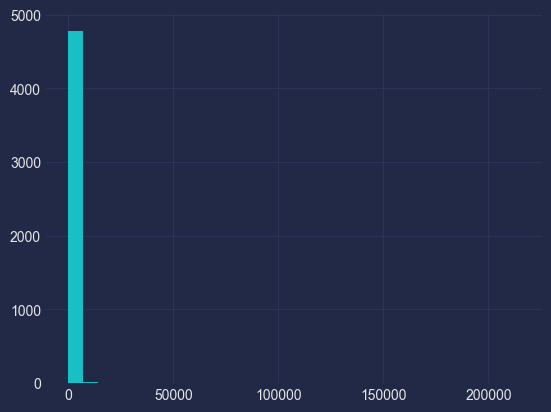

In [9]:
df['Price Per SQFT'].hist(bins=30)

In [10]:
#removing outliers

price_mean=df['Price Per SQFT'].mean()
price_std=df['Price Per SQFT'].std()

df=df.query("@price_mean-3*@price_std<`Price Per SQFT`<@price_mean+3*@price_std")

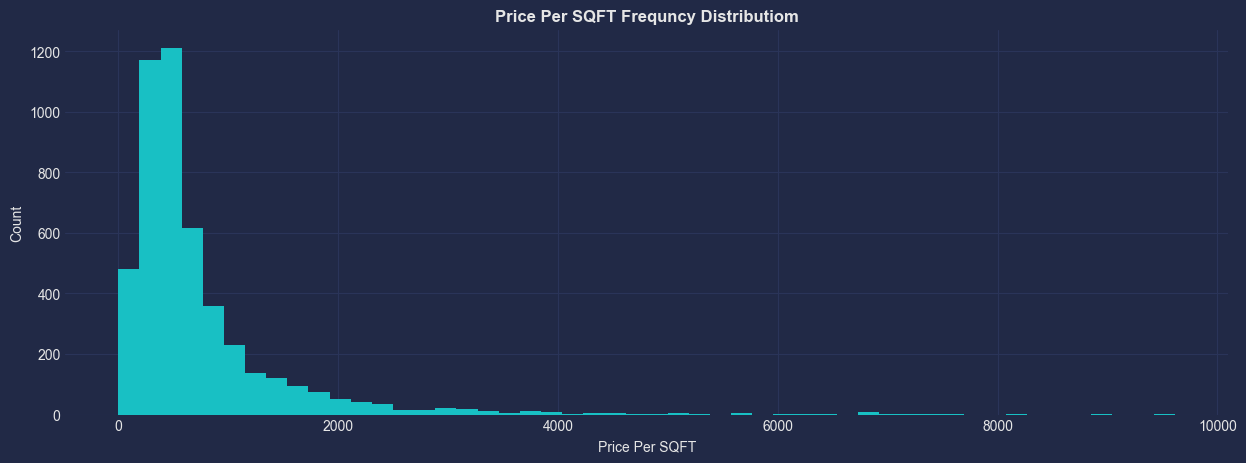

In [11]:
plt.figure(figsize=(15,5))
df['Price Per SQFT'].hist(bins=50)
plt.title('Price Per SQFT Frequncy Distributiom',fontweight='bold')
plt.xlabel('Price Per SQFT')
plt.ylabel('Count')
plt.show()

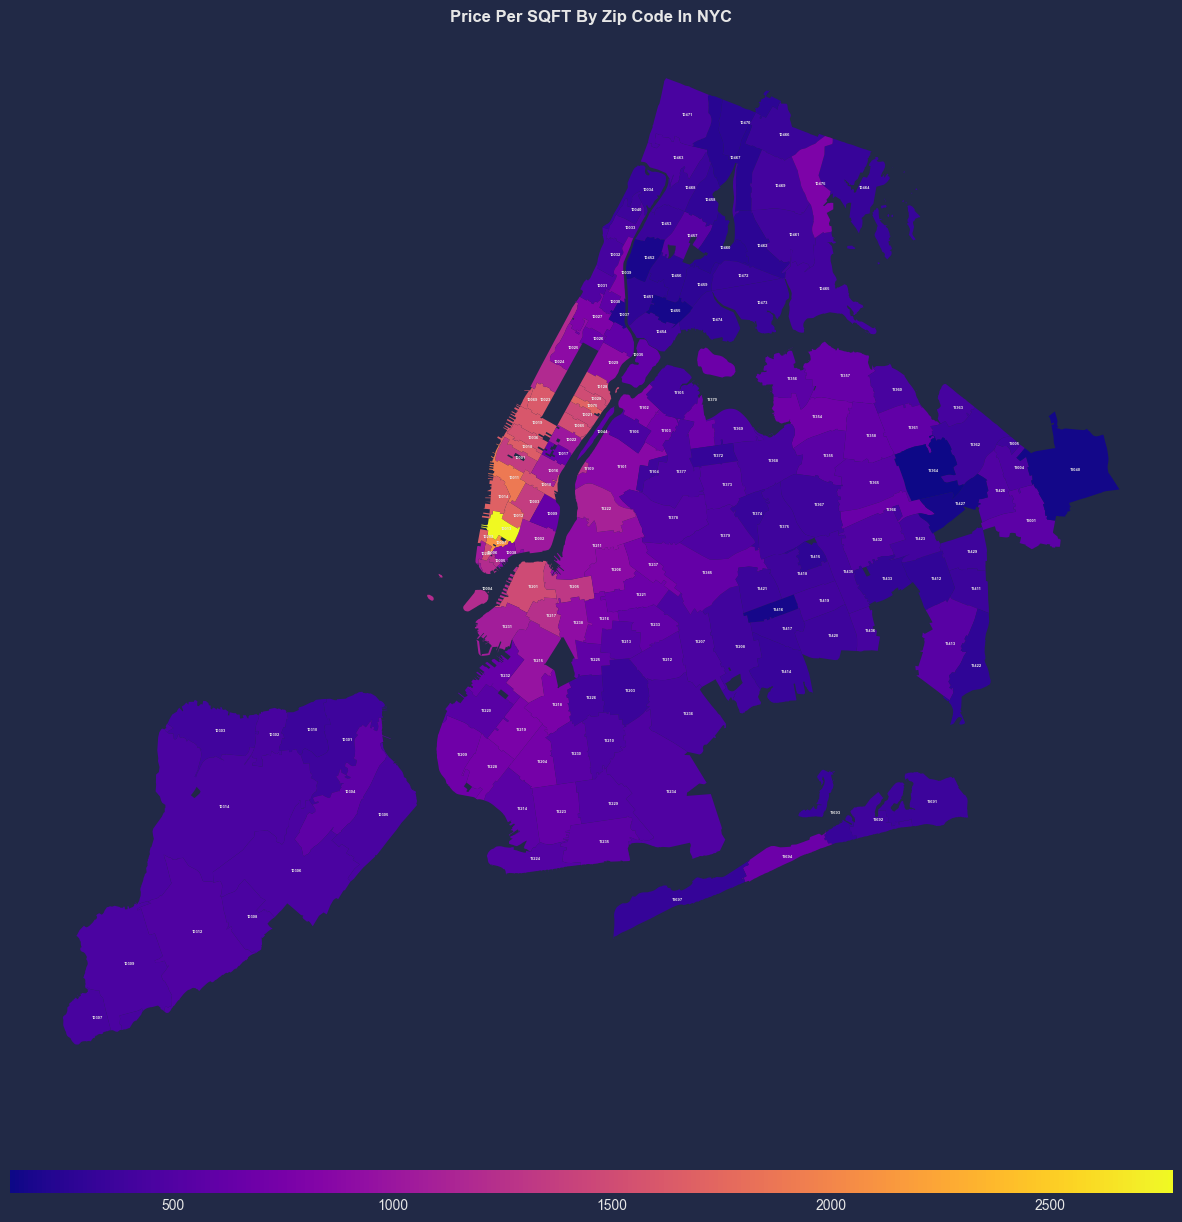

In [12]:
grouped=df.groupby('ZipCode')['Price Per SQFT'].mean().reset_index()
merged=grouped.merge(ny[['GEOID10','geometry']],left_on='ZipCode',right_on='GEOID10')
merged=geopandas.GeoDataFrame(merged)
merged['X']=merged.geometry.centroid.x
merged['Y']=merged.geometry.centroid.y

fig,ax=plt.subplots(figsize=(15,20))
merged.plot(ax=ax,column='Price Per SQFT',cmap='plasma',
            legend=True,legend_kwds={'orientation':'horizontal','pad':0.05,'aspect':50}
            )
ax.set_title('Price Per SQFT By Zip Code In NYC',fontweight='bold')
for i in range(merged['ZipCode'].nunique()):
    ax.text(merged['X'].iloc[i],merged['Y'].iloc[i],merged['ZipCode'].iloc[i],size=3,fontweight='bold',va='center')
ax.axis('off')
plt.show()

In [13]:
fig=px.scatter_mapbox(df,lon='LONGITUDE',lat='LATITUDE',zoom=9,
                      color='Price Per SQFT',color_continuous_scale='plasma',
                      size=df['Price Per SQFT'],
                      hover_name='STATE')
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600,width=1200, margin=dict(l=0, r=0, t=0, b=0),template='plotly_dark')
fig.update_layout(title=dict(text='Dispersion Of Apartments For Sales',font_family='Arial Black'))
#fig.update_traces(marker=dict(color=df['Price Per SQFT'],colorscale='plasma',size=3))
fig.update_layout(coloraxis_showscale=False)

In [14]:
fig=px.box(df,x='SUBLOCALITY',y='Price Per SQFT')
fig.update_layout(height=500,width=1100,template='plotly_dark')
fig.update_layout(title=dict(text='Price Per SQFT Frequency Distribution By Sublocality',font_family='Arial Black'))
fig.update_yaxes(type='log')